# Neural Networks using Spectograms

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import tensorflow
import os
import cv2
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications import ResNet50
from skimage.transform import resize
from keras.applications.resnet50 import preprocess_input

## Save spectrograms arrays to file in order to speed up loading data

In [ ]:
mel_spectogram_data = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/mel_spectrograms'
mfcc_spectogram_data = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/mfcc_spectrograms'
standard_spectogram_data = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/standard_spectrograms'

In [ ]:
def load_spectograms(spectogram_data):
  X, y, classes = [], [], []

  for label, genre in enumerate(os.listdir(spectogram_data)):
      classes.append(genre)
      genre_path = os.path.join(spectogram_data, genre)

      if os.path.isdir(genre_path):
          for img_file in os.listdir(genre_path):
              img_path = os.path.join(genre_path, img_file)

              if os.path.isfile(img_path):
                  img = load_img(img_path)
                  img_array = img_to_array(img)
                  X.append(img_array)
                  y.append(genre)

  X = np.array(X)
  y = np.array(y)

  print(X.shape, y.shape, classes)

  return X, y, classes

In [ ]:
mfcc_X, mfcc_y, mfcc_classes = load_spectograms(mfcc_spectogram_data)
mel_X, mel_y, mel_classes = load_spectograms(mel_spectogram_data)
standard_X, standard_y, standard_classes = load_spectograms(standard_spectogram_data)

np.save('X.npy', mfcc_X)
np.save('y.npy', mfcc_y)
np.save('classes.npy', mfcc_classes)

np.save('X.npy', mel_X)
np.save('y.npy', mel_y)
np.save('classes.npy', mel_classes)

np.save('X.npy', standard_X)
np.save('y.npy', standard_y)
np.save('classes.npy', standard_classes)

(999, 308, 465, 1) (999,) ['reggae', 'blues', 'metal', 'country', 'rock', 'hiphop', 'classical', 'jazz', 'disco', 'pop']
(996, 308, 465, 1) (996,) ['reggae', 'blues', 'metal', 'country', 'rock', 'hiphop', 'classical', 'jazz', 'disco', 'pop']
(999, 308, 465, 1) (999,) ['reggae', 'blues', 'metal', 'country', 'rock', 'hiphop', 'classical', 'jazz', 'disco', 'pop']


## Load spectogram images

In [22]:
spectogram_dir = '/content/drive/MyDrive/GoogleCollab/Data/GTZAN/spectrograms/mel_spectrograms'

X = np.load(os.path.join(spectogram_dir, 'X.npy'))
y = np.load(os.path.join(spectogram_dir, 'y.npy'))
classes = np.load(os.path.join(spectogram_dir, 'classes.npy'))

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded)

print(y_onehot.shape)
print(X.shape, y.shape, classes)

(996, 10)
(996, 308, 465, 3) (996,) ['reggae' 'blues' 'metal' 'country' 'rock' 'hiphop' 'classical' 'jazz'
 'disco' 'pop']


# Build Neural Network models

## NN Model 1

In [4]:
def create_nn_model_1():
  model = Sequential(name='Model_1')
  model.add(Conv2D(64, 2, activation = 'relu', input_shape = X.shape[1:]))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.1))
  model.add(Conv2D(128, 2, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.1))
  model.add(Conv2D(256, 2, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (4,4)))
  model.add(Dropout(0.1))
  model.add(Conv2D(512, 2, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (8,8)))
  model.add(Dropout(0.1))

  model.add(Flatten())

  model.add(Dense(2048, activation = 'relu'))
  model.add(Dense(1024, activation = 'relu'))
  model.add(Dense(256, activation = 'relu'))
  model.add(Dense(128, activation = 'relu'))

  model.add(Dense(10, activation = 'softmax'))
  # model.summary()

  return model

In [5]:
def model_1_compile(model, checkpoint_path):
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.01)
  checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

  return model, reduce_lr, checkpoint

## NN Model 2

In [ ]:
def create_nn_model_2():
  model = Sequential(name='Model_2')
  model.add(Conv2D(64, 2, activation = 'relu', input_shape = X.shape[1:]))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(32, 2, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.5))
  model.add(Conv2D(32, 2, activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))

  model.add(Flatten())

  model.add(Dense(64, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(32, activation = 'relu'))
  model.add(BatchNormalization())
  model.add(Dense(16, activation = 'relu'))
  model.add(BatchNormalization())

  model.add(Dense(10, activation = 'softmax'))
  # model.summary()

  return model

## NN Model 3

In [ ]:
def create_nn_model_3():
  model = Sequential(name='Model_3')
  model.add(Conv2D(64, (3, 3), input_shape = X.shape[1:], padding="same", activation='relu'))
  model.add(Conv2D(64, (3, 3), strides=(4, 4), padding="same", activation='relu'))
  model.add(Dropout(0.25))
  model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
  model.add(Conv2D(128, (3, 3), strides=(4, 4), padding='same', activation='relu'))
  model.add(Dropout(0.25))

  model.add(Flatten())

  model.add(Dense(1024, activation=LeakyReLU(alpha=0.1)))
  model.add(BatchNormalization())

  model.add(Dense(512, activation=LeakyReLU(alpha=0.1)))
  model.add(BatchNormalization())

  model.add(Dense(256, activation=LeakyReLU(alpha=0.1)))
  model.add(BatchNormalization())

  model.add(Dense(10, activation = 'softmax'))
  # model.summary()

  return model

## ResNet50

In [3]:
def create_nn_model_4():
  resnet = ResNet50(weights='imagenet', include_top=False, classes=10)
  print("ResNet50 layers:",len(resnet.layers))

  model = resnet.output
  model = GlobalAveragePooling2D()(model)
  model = Dense(1024, activation = 'relu')(model)
  model = Dense(512, activation = 'relu')(model)
  last_layer = Dense(10, activation = 'softmax')(model)
  model = Model(name="Model_ResNet50", inputs = resnet.input, outputs = last_layer)

  print("Combined model:",len(model.layers),'layers')

  for layer in model.layers[:175]:
    layer.trainable = False

  for layer in model.layers[175:]:
      layer.trainable = True

  return model

In [13]:
def resnet_compile(model, checkpoint_path):
  lr_schedule = tensorflow.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=1e-6)

  optimizer = RMSprop(learning_rate=lr_schedule)

  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

  return model, checkpoint

# Split the data

In [16]:
X = preprocess_input(X) # Prepare X-array for ResNet model

X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, shuffle=True)
print(X_train.shape, X_test.shape, y_test.shape)

(796, 308, 465, 3) (200, 308, 465, 3) (200, 10)


# Create subdirectories for checkpoints & compile model

In [17]:
model = create_nn_model_4()

ResNet50 layers: 175
Combined model: 179 layers


In [18]:
checkpoint_dir = "/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/"
checkpoint_subdir = os.path.join(checkpoint_dir, model._name)
if not os.path.exists(checkpoint_subdir):
  os.makedirs(checkpoint_subdir)

checkpoint_path = os.path.join(checkpoint_subdir, "mel_best_model.h5")

In [19]:
model, checkpoint = resnet_compile(model, checkpoint_path)
# model, reduce_lr, checkpoint = model_1_compile(model, checkpoint_path)

# Train model

In [20]:
import shutil

def save_history(history):
  filename = f'{model._name}_history.npy'
  np.save(filename, H.history)
  content_dir = "/content/" + filename
  checkpoint_dir = "/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/" + model._name
  shutil.copy(content_dir, checkpoint_dir)

In [21]:
H = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=60, batch_size=32, callbacks=[checkpoint])
loss, accuracy = model.evaluate(X_test, y_test)
save_history(H)

print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/60
25/25 [==============================] - ETA: 0s - loss: 1.7105 - accuracy: 0.4209
Epoch 1: val_accuracy improved from -inf to 0.43500, saving model to /content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_ResNet50/mel_best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 17s 561ms/step - loss: 1.7105 - accuracy: 0.4209 - val_loss: 1.6518 - val_accuracy: 0.4350
Epoch 2/60
25/25 [==============================] - ETA: 0s - loss: 1.1779 - accuracy: 0.6156
Epoch 2: val_accuracy improved from 0.43500 to 0.59000, saving model to /content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_ResNet50/mel_best_model.h5
25/25 [==============================] - 10s 410ms/step - loss: 1.1779 - accuracy: 0.6156 - val_loss: 1.2242 - val_accuracy: 0.5900
Epoch 3/60
25/25 [==============================] - ETA: 0s - loss: 1.0284 - accuracy: 0.6508
Epoch 3: val_accuracy improved from 0.59000 to 0.59500, saving model to /content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/Model_ResNet50/mel_best_model.h5
25/25 [==============================] - 10s 424ms/step - loss: 1.0284 - accuracy: 0.6508 - val_loss: 1.2251 - val_accuracy: 0.5950
Epoch 4/60
25/25 [==============================] - ETA: 0s - loss: 0.8976 - accuracy: 0

# Calculate model metrics

In [23]:
checkpoint_dir = "/content/drive/MyDrive/GoogleCollab/Data/GTZAN/checkpoints/"
models_dict = {}

for directory in os.listdir(checkpoint_dir):
  if directory == "Model_ResNet50":
    X = preprocess_input(X)

  X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42, shuffle=True)
  best_model_path = os.path.join(checkpoint_dir, directory)
  best_model = tensorflow.keras.models.load_model(best_model_path + "/mel_best_model.h5")

  predict_results = best_model.predict(X_test)

  y_pred = np.argmax(predict_results, axis=1)
  y_test = np.argmax(y_test, axis=1)

  history = f"{checkpoint_dir}{directory}/{directory}_history.npy"

  model_dict = {'y_pred': y_pred, 'y_test': y_test, 'history': history}
  models_dict[str(directory)] = model_dict

7/7 [==============================] - 3s 285ms/step


In [24]:
for model in models_dict:
  y_pred = models_dict.get(model).get('y_pred')
  y_test = models_dict.get(model).get('y_test')
  accuracy = accuracy_score(y_test, y_pred)
  report = classification_report(y_test, y_pred, target_names=classes)
  print(str(model) + " statistics")
  print(report)
  print(f'Accuracy: {accuracy:.4f}' + '\n')

Model_1 statistics
              precision    recall  f1-score   support

      reggae       0.40      0.43      0.41        14
       blues       0.76      0.94      0.84        17
       metal       0.41      0.61      0.49        23
     country       0.68      0.70      0.69        27
        rock       0.65      0.57      0.60        23
      hiphop       0.69      0.75      0.72        12
   classical       0.83      0.77      0.80        26
        jazz       0.55      0.33      0.41        18
       disco       0.38      0.38      0.38        21
         pop       0.38      0.26      0.31        19

    accuracy                           0.58       200
   macro avg       0.57      0.57      0.57       200
weighted avg       0.58      0.58      0.57       200

Accuracy: 0.5800

Model_ResNet50 statistics
              precision    recall  f1-score   support

      reggae       0.70      0.50      0.58        14
       blues       0.94      0.94      0.94        17
       metal   

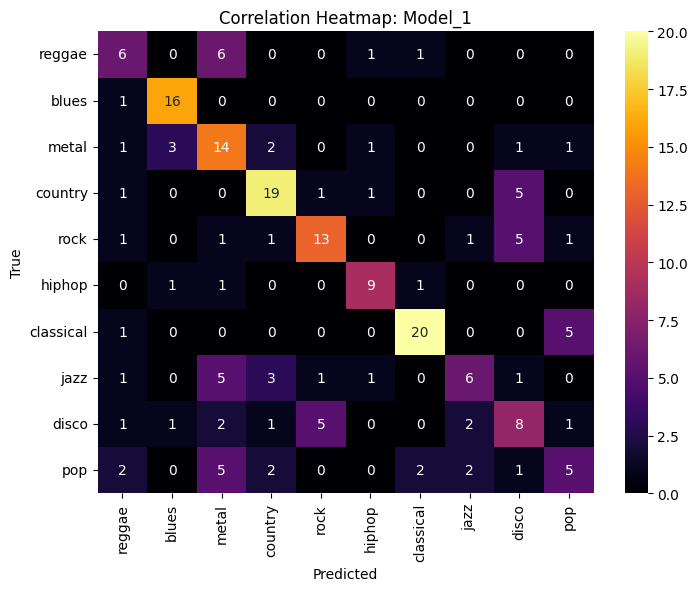

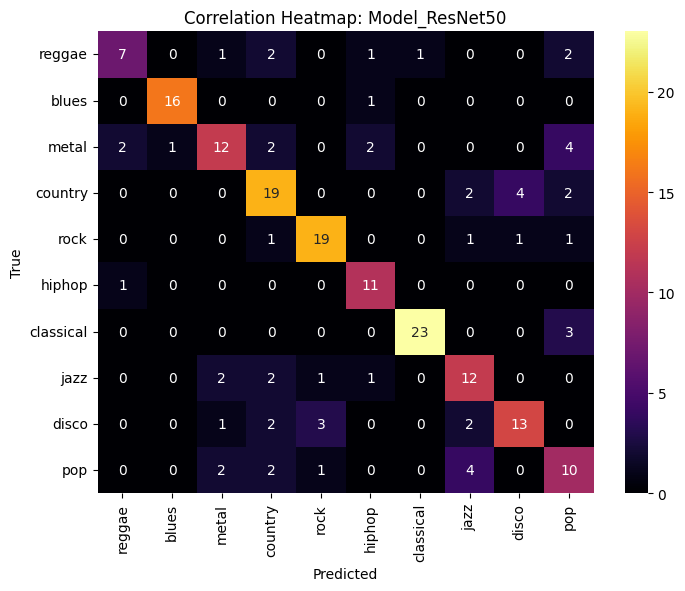

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for model in models_dict:
  y_pred = models_dict.get(model).get('y_pred')
  y_test = models_dict.get(model).get('y_test')
  cm = confusion_matrix(y_test, y_pred)

  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='inferno', xticklabels=classes, yticklabels=classes)
  plt.title('Correlation Heatmap: ' + str(model))
  plt.xlabel('Predicted')
  plt.ylabel('True')
  plt.show()

In [27]:
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(history['accuracy'], label='Train Accuracy')
    ax1.plot(history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    ax2.plot(history['loss'], label='Train Loss')
    ax2.plot(history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')

    fig.suptitle(model_name, fontsize=16)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the main title
    plt.show()

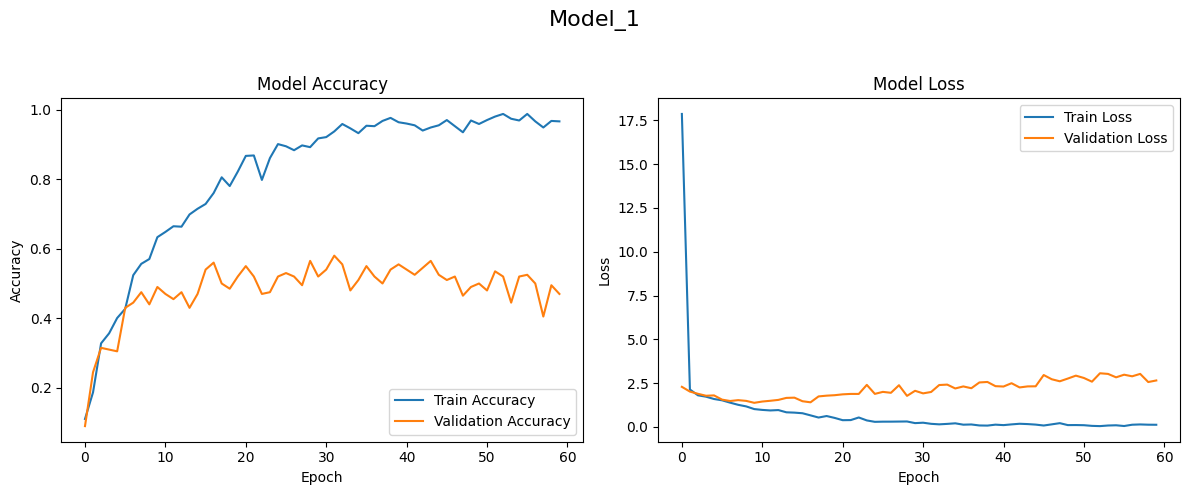

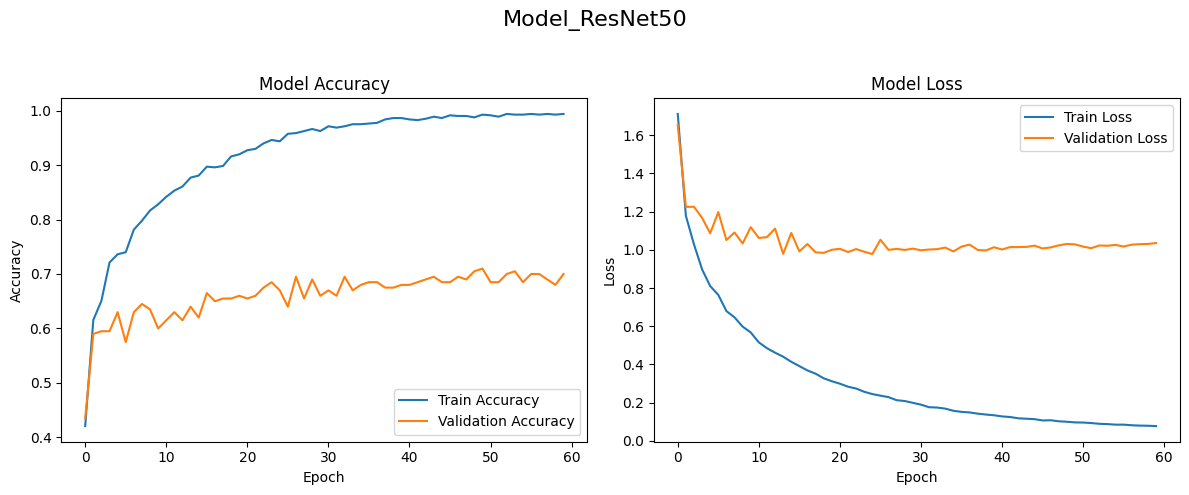

In [28]:
for model in models_dict:
  history = np.load(models_dict.get(model).get('history'), allow_pickle='TRUE').item()
  plot_history(history, model)